In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Embedding, LSTM, Dense
from keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as SumyTokenizer
from sumy.summarizers.lsa import LsaSummarizer


In [2]:
# Load DataFrame
df = pd.read_csv("./1429_1.csv")
data = df[["id","reviews.text","reviews.rating"]]
data = data.dropna()

/var/folders/j_/87xszm515zj_hxwrzm288c2m0000gn/T/ipykernel_67162/3111342799.py:2: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./1429_1.csv")


In [4]:
# Sentiment words word cloud
words = ['awesome','great','fantastic','extraordinary','amazing','super',
         'magnificent','stunning','impressive','wonderful','breathtaking',
         'love','content','pleased','happy','glad','satisfied','lucky',
         'shocking','cheerful','wow','sad','unhappy','horrible','regret',
         'bad','terrible','annoyed','disappointed','upset','awful','hate']

In [5]:
rt = " ".join(data['reviews.text'])
diz = {}
for word in rt.split(" "):
    if word in words:
        diz[word] = diz.get(word,0)+1

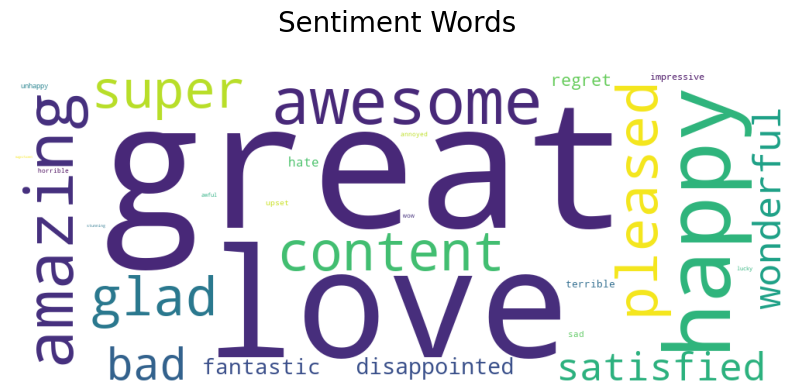

In [6]:
wordcloud = WordCloud(background_color='white', width=1000, height=400).generate_from_frequencies(diz)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.title('Sentiment Words\n', size=20)
plt.axis('off')
plt.show()

In [7]:
# Combine multiple datasets
df2 = pd.read_csv("./archive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
df3 = pd.read_csv("./archive/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
data2 = df2[["id","reviews.text","reviews.rating"]]
data3 = df3[["id","reviews.text","reviews.rating"]]
data2 = data2[data2["reviews.rating"]<=3]
data3 = data3[data3["reviews.rating"]<=3]
frames = [data, data2, data3]
final = pd.concat(frames)

In [8]:
# Data preprocessing
final['reviews.text'].fillna('', inplace=True)
final["reviews.text"]=final["reviews.text"].str.lower()
final['reviews.text'] = final.apply(lambda row: word_tokenize(row['reviews.text']), axis=1)
final["reviews.text"] = final['reviews.text'].apply(lambda x: [item for item in x if item.isalpha()])
final['reviews.text'] = final['reviews.text'].apply(lambda x : [WordNetLemmatizer().lemmatize(y) for y in x])
stop = set(stopwords.words('english'))
final['reviews.text'] = final['reviews.text'].apply(lambda x: [item for item in x if item not in stop])
final["reviews.text"] = final["reviews.text"].apply(lambda x: str(' '.join(x)))

In [9]:
# Map ratings to sentiments
sentiment = {1: 0, 2: 0, 3: 1, 4: 2, 5: 2}
final["sentiment"] = final["reviews.rating"].map(sentiment)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_df=0.9)
text = vectorizer.fit_transform(final["reviews.text"])
final["sentiment"] = final["reviews.rating"].map(sentiment)


In [10]:
# Tokenization and Padding
t = Tokenizer()
t.fit_on_texts(final["reviews.text"])
max_length = max([len(s.split()) for s in final["reviews.text"]])
vocab_size = len(t.word_index) + 1
X_train, X_test, y_train, y_test = train_test_split(final["reviews.text"], final["sentiment"], test_size=0.25)
X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=max_length, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=max_length, padding="post", truncating="post")
X_train = X_train[0:28290]
y_train = y_train[0:28290]
X_test = X_test[0:9430]
y_test = y_test[0:9430]
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [11]:
# Model Training
embedding_dim = 200
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(LSTM(units=32))
model.add(Dense(3, activation="softmax"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, batch_size=10, epochs=10)

Epoch 1/10
2829/2829 [==============================] - 349s 123ms/step - loss: 0.3095 - accuracy: 0.8580
Epoch 2/10
2829/2829 [==============================] - 345s 122ms/step - loss: 0.3076 - accuracy: 0.8580
Epoch 3/10
2829/2829 [==============================] - 346s 122ms/step - loss: 0.3075 - accuracy: 0.8580
Epoch 4/10
2829/2829 [==============================] - 344s 121ms/step - loss: 0.3074 - accuracy: 0.8580
Epoch 5/10
2829/2829 [==============================] - 347s 123ms/step - loss: 0.3075 - accuracy: 0.8580
Epoch 6/10
2829/2829 [==============================] - 352s 124ms/step - loss: 0.3073 - accuracy: 0.8580
Epoch 7/10
2829/2829 [==============================] - 351s 124ms/step - loss: 0.3074 - accuracy: 0.8580
Epoch 8/10
2829/2829 [==============================] - 352s 124ms/step - loss: 0.3072 - accuracy: 0.8580
Epoch 9/10
2829/2829 [==============================] - 350s 124ms/step - loss: 0.3073 - accuracy: 0.8580
Epoch 10/10
2829/2829 [=======================

In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(x=X_test, y=y_test, batch_size=10)
print("Loss:", loss)
print("Test Accuracy:", accuracy)

943/943 [==============================] - 27s 29ms/step - loss: 0.3167 - accuracy: 0.8520
Loss: 0.3167138397693634
Test Accuracy: 0.8519618511199951


In [13]:
pd.DataFrame(history.history)

,loss,accuracy
0,0.309544,0.858042
1,0.307606,0.858042
2,0.307458,0.858042
3,0.307404,0.858042
4,0.307481,0.858042
5,0.307309,0.858042
6,0.307448,0.858042
7,0.307207,0.858042
8,0.307262,0.858042
9,0.307150,0.858042


In [14]:
# Predict on test data
y_pred = model.predict(X_test)


295/295 [==============================] - 17s 58ms/step


In [15]:
# Flatten y_test and y_pred arrays
y_test_flat = np.array(y_test).flatten()
y_pred_flat = np.array(y_pred).flatten()

# Create DataFrame with 1-dimensional arrays
comparison_df = pd.DataFrame({'Actual': y_test_flat, 'Predicted': y_pred_flat})
print(comparison_df)

       Actual  Predicted
0         0.0   0.015300
1         0.0   0.021423
2         1.0   0.963277
3         0.0   0.015300
4         0.0   0.021423
...       ...        ...
28285     0.0   0.021423
28286     1.0   0.963277
28287     0.0   0.015300
28288     0.0   0.021423
28289     1.0   0.963277

[28290 rows x 2 columns]


In [16]:
from sklearn.metrics import classification_report

# Function to convert probabilities to class predictions
def convert_to_class(predictions):
    return np.argmax(predictions, axis=1)

# Predict sentiments for the test data
test_predictions = model.predict(X_test)
predicted_sentiments = convert_to_class(test_predictions)

# Convert one-hot encoded true labels to single label format
true_sentiments = np.argmax(y_test, axis=1)

# Calculate classification report
report = classification_report(true_sentiments, predicted_sentiments, target_names=['Negative', 'Neutral', 'Positive'])

# Print the classification report
print("Classification Report:")
print(report)


295/295 [==============================] - 17s 59ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       634
     Neutral       0.00      0.00      0.00       762
    Positive       0.85      1.00      0.92      8034

    accuracy                           0.85      9430
   macro avg       0.28      0.33      0.31      9430
weighted avg       0.73      0.85      0.78      9430



/Users/adipratyush/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adipratyush/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adipratyush/Library/Python/3.11/lib/python/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

In [17]:
model.save("amazon_sentiment_model.h5")
print("Model saved successfully..!")

Model saved successfully..!


/Users/adipratyush/Library/Python/3.11/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to extract reviews from an Amazon product page
def extract_reviews_from_amazon(url):
    # Send an HTTP GET request to the provided URL
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content of the webpage
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract review elements
        review_elements = soup.find_all('div', class_='a-section review aok-relative')
        
        reviews = []
        
        # Iterate over each review element
        for review_element in review_elements:
            # Extract review text if available
            review_text_element = review_element.find('span', {'data-hook': 'review-body'})
            review_text = review_text_element.get_text(strip=True) if review_text_element else ""
            
            # Extract review rating if available
            review_rating_element = review_element.find('span', class_='a-icon-alt')
            review_rating = review_rating_element.get_text(strip=True) if review_rating_element else ""
            
            # Append review text and rating to the list
            reviews.append((review_text, review_rating))
        
        return reviews
    else:
        print("Failed to fetch page:", response.status_code)
        return []



In [19]:
# Load the saved model
loaded_model = load_model("amazon_sentiment_model.h5")
print("Model loaded successfully.")

Model loaded successfully.


In [20]:
# Function to predict sentiment from Amazon product link
def predict_sentiment_from_amazon(url):
    reviews = extract_reviews_from_amazon(url)
    # Check if reviews are empty
    if not reviews:
        print("No reviews found on the provided Amazon product page.")
        return []

    review_texts = [review[0] for review in reviews]
    review_texts = t.texts_to_sequences(review_texts)
    review_texts = pad_sequences(review_texts, maxlen=max_length)
    predictions = loaded_model.predict(review_texts)
    predicted_sentiments = np.argmax(predictions, axis=1)
    return predicted_sentiments


In [21]:
# Prompt user for the product link and predict sentiment
amazon_product_url = input("Enter Amazon product URL: ")
predicted_sentiments = predict_sentiment_from_amazon(amazon_product_url)
print("Predicted Sentiments:", predicted_sentiments)

1/1 [==============================] - 0s 182ms/step
Predicted Sentiments: [2 2 2 2 2 2 2 2]


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to generate a summary of reviews using TF-IDF text summarization
def generate_summary(reviews_text):
    # Initialize TF-IDF vectorizer
    tfidf_vectorizer = TfidfVectorizer()

    # Fit and transform the reviews text
    tfidf_matrix = tfidf_vectorizer.fit_transform(reviews_text)

    # Compute similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

    # Find the sentence scores based on similarity matrix
    sentence_scores = similarity_matrix.sum(axis=1)

    # Sort sentences by score and select the top ones for summary
    top_sentences_indices = sentence_scores.argsort()[-2:][::-1]  # Select top 2 sentences
    summary_sentences = [reviews_text[i] for i in top_sentences_indices]

    # Join the summary sentences to form the summary
    summary = " ".join(summary_sentences)

    return summary

reviews = extract_reviews_from_amazon(amazon_product_url)  # Retrieve reviews
reviews_text = [review[0] for review in reviews]  # Extract review texts
summary = generate_summary(reviews_text)
print("Summary of Reviews:")
print(summary)


Summary of Reviews:
I was looking for something lightweight and affordable for music on the go. I am coming from using Sound Blaster JAM as my daily go to headphones, they were featherlight and comfortable. Despite being slightly heavier than the former, I found the Sony CH520s to be comfortable and solidly built. The sound quality is great with some good bass and I found it to be a substantial upgrade. The tuning found in the app is good and the battery life is excellent. I got nothing to complain!Read more Great option for those who just want some basic headphones. The sound quality is great, in my opinion. Definitely can hear outside noises but personally I like to be aware so not a problem for me. And they’re not as bulky as some headphones can look, they’re pretty sleek and very lightweight.Read more
